In [1]:
'''
This is an agent based implementation of question asnwer RAG
based on user uploaded PDF files
'''

import os
from typing import List
from pprint import pprint
from dotenv import load_dotenv
from IPython.display import display
from ipywidgets import FileUpload, Label
from typing_extensions import TypedDict
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import END, StateGraph

In [2]:
# Define all the needed parameters for OpenAI APIs

load_dotenv()
api_key = os.environ.get('AZURE_OPENAI_API_KEY')
api_endpoint = os.environ.get('AZURE_OPENAI_ENDPOINT')
deployment_textgen = os.environ.get('AZURE_DEPLOYMENT_TEXTGEN')
deployment_embed = os.environ.get('AZURE_DEPLOYMENT_EMBED')
api_version = os.environ.get('AZURE_OPENAI_VERSION')

In [3]:
# Defining llm and embeddings models

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=api_endpoint,
    openai_api_type='azure',
    deployment=deployment_embed,
    openai_api_key=api_key,
    chunk_size=1
)

llm = AzureChatOpenAI(
    azure_endpoint=api_endpoint,
    openai_api_key=api_key,
    openai_api_version=api_version,
    deployment_name=deployment_textgen,
    temperature=0
)

In [4]:
# Validator class for document relevance score

class DocumentRelevaceScore(BaseModel):
    ''' Simple class to format LLM generate JSON '''

    score: str = Field(description="Relevance score. Values are yes or no")

parser = PydanticOutputParser(pydantic_object=DocumentRelevaceScore)

In [5]:
def persistent_retriver(embed=embeddings, search_type="similarity", k=3):
    '''
    Create a Chroma instance and a document retriver. If there is a
    db directory exising then read from it. If not, initialize a new db

    Args:
        embeddings (LangchainEmbeddings): Embedding function to use for
                                          retriever
    '''

    persist_directory = './chroma/'
    if os.path.isdir(persist_directory):
        print("Reading from persistent DB")
        vectordb = Chroma(
            persist_directory=persist_directory,
            embedding_function=embed
        )
    else:
        print("Creating persistent DB")
        vectordb = Chroma(
            embedding_function=embed,
            persist_directory=persist_directory
        )

    return vectordb, vectordb.as_retriever(
        search_type=search_type,
        search_kwargs={"k": k}
    )

db, retriever = persistent_retriver()

Reading from persistent DB


In [6]:
# Index a file

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, chunk_overlap=50
)

def index_document(file, splitter=text_splitter, vectordb=db):
    """
    Adds a document to vector database

    Args:
        file(str): path to file
        splitter(langchain_text_splitters.base.TextSplitter): text splitter
        vectordb(langchain_community.vectorstores.chroma.Chroma): DB instance
    """

    try:
        doc = PyPDFLoader(file).load()
        chunks = splitter.split_documents(doc)
        vectordb.add_documents(chunks)
    except Exception as e:
        print(f'{e}')

In [7]:
# Display Upload widget allowing upload pdf files
# The widget triggers file indexing upon upload

# create 'docs' directory if it doesn't exist
if not os.path.exists('docs'):
    os.makedirs('docs')

# create a FileUpload widget
upload = FileUpload(accept='.pdf', multiple=False)
label = Label("Empty")

def on_upload_change(change):
    '''
    Overwriting FileUpload listener to trigger file saving
    and indexing actions
    '''

    file_name = change['new'][0]['name']
    file_content = change['new'][0]['content']
    label.value = file_name

    # save file to documents directory
    try:
        with open(f'docs/{file_name}', 'wb') as f:
            f.write(file_content)
    except Exception as e:
        print(f'File writing error: {e}')

    # index the file and add to embedding store
    index_document(f'docs/{file_name}')

upload.observe(on_upload_change, names='value')
display(upload, label)

FileUpload(value=(), accept='.pdf', description='Upload')

Label(value='Empty')

In [8]:
# Retrieval Grader - checks if there are relevant documents
# among the retived ones

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved
    document to a user question. If the document contains keywords
    related to the user question, grade it as relevant. It does not
    need to be a stringent test. The goal is to filter out erroneous
    retrievals. Give a binary score 'yes' or 'no' score to indicate
    whether the document is relevant to the question.
    Provide the binary score as a JSON with a single key 'score' and
    no premable or explaination.\n
    {format_instructions}\n\n
    Here is the retrieved document: \n {document} \n
    Here is the user question: {question} """,
    input_variables=["question", "document"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

retrieval_grader = prompt | llm | parser

In [9]:
# Generate answer

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know. Use only
    information that is available in context.
    Keep the answer concise
    Question: {question}
    Context: {context}
    Answer: """,
    input_variables=["question", "document"],
)

# Post-processing
def format_docs(docs):
    ''' During streaming concatenate everything to a string '''
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

In [10]:
# Define functionalities of the graph and its nodes

# State

class GraphState(TypedDict):
    """
    Represents the state of the graph.

    Attributes:
        question: question
        generation: LLM answer generation
        enough_context: whether there is context for generation
        documents: list of documents
    """

    question: str
    generation: str
    enough_context: str
    documents: List[str]

# Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents,
        that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation,
        that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "documents": documents,
        "question": question,
        "generation": generation
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to
    the question. If any document is not relevant, we will set a
    flag to indicate absense of the relevant context for generation

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated
        enough_context state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    enough_context = "yes"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to stop and not
            # generate the answer
            enough_context = "no"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "enough_context": enough_context
    }


# Conditional edge

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or stop as there is not
    context for the generation

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    enough_context = state["enough_context"]

    if enough_context == "no":
        # All documents have been filtered check_relevance
        print(
            "---DECISION: SOME DOCUMENTS ARE NOT RELEVANT TO QUESTION, STOP---"
        )
        return "stop"

    # We have relevant documents, so generate answer
    print("---DECISION: GENERATE---")
    return "generate"


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae

In [11]:
# Build graph connecting nodes with edges

workflow.set_entry_point(
    "retrieve"
)

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "generate": "generate",
        "stop": END,
    },
)

workflow.add_edge("generate", END)

In [12]:
# Compile
app = workflow.compile()

In [13]:
def qa_streaming(question):
    '''
    Helper funtion invoking the RAG graph

    Args:
        question(str): User input / question
    '''

    inputs = {"question": question}
    for output in app.stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")

    try:
        value
    except NameError:
        print("Something went wrong generating answer")

    else:
        if "generation" in value:
            pprint(value["generation"])
        else:
            print("There was not enough context for an answer")

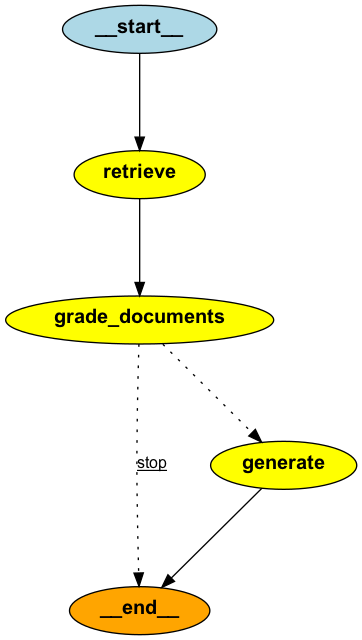

In [14]:
from IPython.display import Image

Image(app.get_graph().draw_png())

In [14]:
# Test 1 -

qa_streaming("What is Retrieval-Augmented Generative Agent?")

---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
'Finished running: generate:'
('Retrieval-Augmented Generative Agent (RAG) is an agent that performs '
 'information retrieval across full-text scientific articles and uses RAG '
 'models to provide answers to questions over the scientific literature.')


In [15]:
# Test 2

qa_streaming("How to choose a mating partner for a dog?")

---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
'Finished running: generate:'
('Choose a mating partner for a dog by ensuring that both the sire and dam are '
 'AKC registered. Select a dog whose bloodlines will strengthen the weaknesses '
 'and emphasize the good qualities of the bitch. Consider the factors that '
 "contribute to the dogs' traits and appearances. Study the pedigrees of the "
 'mating pair and be knowledgeable about the genetic problems that affect the '
 'breed.')


In [16]:
# Test 3

qa_streaming("What are the main difference between Volvo and Kia?")

---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME DOCUMENTS ARE NOT RELEVANT TO QUESTION, STOP---
'Finished running: grade_documents:'
There was not enough context for an answer


### Unit Tests

In [17]:
import unittest

class TestIndexDocument(unittest.TestCase):

    def setUp(self):
        self.file_path = 'test_docs/guide_to_breeding_your_dog.pdf'
        self.splitter = text_splitter
        self.vectordb = db

    def test_index_document_valid_file(self):
        index_document(self.file_path, self.splitter, self.vectordb)
        self.assertTrue(True)  # Add an assertion to verify the expected behavior

    def test_index_document_invalid_file_format(self):
        try:
            index_document('test_docs/bad_pdf.pdf', self.splitter, self.vectordb)
        except Exception as e:
            self.assertEqual(str(e), 'Wrong PDF format: Invalid file format')

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

invalid pdf header: b'safas'
EOF marker not found
EOF marker not found
.

Stream has ended unexpectedly


.
----------------------------------------------------------------------
Ran 2 tests in 7.900s

OK
